In [1]:
!pip install lightgbm
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

filepath = '/content/drive/MyDrive/Dataset/sentiment_analysis.csv'  # Change the name if it's different
df = pd.read_csv(filepath)

# Display the first few rows of the dataset
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,CustomerID,Name,Age,Gender,Geography,Native_Place,Marital_Status,Tenure,Account_Type,Balance,...,CreditScore,Loan_Status,EMI_Amount,Exited,Branch_Code,Account_Open_Date,Last_Transaction_Date,Customer_Review,Review_Sentiment,Sentiment_Score
0,CID000001,Sunita Sharma,21,Other,Tamil Nadu,Hyderabad,Married,4,Current,676699.50,...,523,Auto,4238.57,0,BR072,2024-03-10,2024-06-23,Reasonable fees 💲,Neutral,0.733885
1,CID000002,Amit Kumar,53,Male,Karnataka,Pune,Divorced,8,Premium,215313.77,...,667,Business,30226.31,0,BR094,2020-02-26,2024-08-20,Professional staff 🌟,Positive,0.910818
2,CID000003,Rohan Gupta,55,Other,West Bengal,Lucknow,Married,2,Savings,661263.30,...,689,Education,43308.58,0,BR021,2024-04-07,2024-11-21,Great mobile app 🥰,Positive,0.983285
3,CID000004,Sunita Iyer,27,Other,Karnataka,Jaipur,Married,5,NRI,379455.44,...,332,Business,19905.26,0,BR028,2022-02-15,2024-12-11,Professional staff 🌟,Positive,0.910818
4,CID000005,Priya Iyer,76,Male,Tamil Nadu,Bangalore,Married,17,Senior Citizen,747013.80,...,441,Multiple,27711.22,0,BR015,2021-11-16,2024-07-04,Professional staff 🌟,Positive,0.910818


In [5]:
# Check for missing values
print(df.isnull().sum())

# Drop unnecessary columns and process categorical variables
df.drop(['CustomerID', 'Name', 'Account_Open_Date', 'Last_Transaction_Date'], axis=1, inplace=True)

# Convert categorical columns to string type
cat_cols = ['Gender', 'Geography', 'Native_Place', 'Marital_Status', 'Account_Type', 'Loan_Status', 'Branch_Code', 'Review_Sentiment']
df[cat_cols] = df[cat_cols].astype(str)

# Combine all categorical columns into one feature and apply TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

df['combined_cats'] = df[cat_cols].agg(' '.join, axis=1)
tfidf = TfidfVectorizer(max_features=500)
cat_tfidf = tfidf.fit_transform(df['combined_cats'])

# Convert sparse matrix to DataFrame
cat_tfidf_df = pd.DataFrame(cat_tfidf.toarray(), columns=tfidf.get_feature_names_out())
cat_tfidf_df.index = df.index

# Drop original categorical columns
df.drop(cat_cols + ['combined_cats'], axis=1, inplace=True)

# Scale numeric columns
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Monthly_Income', 'CreditScore', 'EMI_Amount', 'Sentiment_Score']
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Final DataFrame after scaling and TF-IDF
df_final = pd.concat([df, cat_tfidf_df], axis=1)

# Display the shape and first few rows of the final dataset
print("Final dataframe shape:", df_final.shape)
df_final.head()


CustomerID               0
Name                     0
Age                      0
Gender                   0
Geography                0
Native_Place             0
Marital_Status           0
Tenure                   0
Account_Type             0
Balance                  0
NumOfProducts            0
HasCrCard                0
IsActiveMember           0
EstimatedSalary          0
Monthly_Income           0
CreditScore              0
Loan_Status              0
EMI_Amount               0
Exited                   0
Branch_Code              0
Account_Open_Date        0
Last_Transaction_Date    0
Customer_Review          0
Review_Sentiment         0
Sentiment_Score          0
dtype: int64
Final dataframe shape: (100000, 160)


,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Monthly_Income,CreditScore,EMI_Amount,...,salary,savings,senior,single,student,tamil,telangana,uttar,west,widowed
0,-1.553360,-0.989785,0.614248,-1.344123,1,0,-1.635106,-1.635106,-0.440697,-1.030932,...,0.0,0.000000,0.000000,0.0,0.0,0.321706,0.0,0.0,0.000000,0.0
1,0.073560,-0.328088,-0.982476,0.443584,0,0,-0.419883,-0.419883,0.386820,0.173194,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.175242,-1.320633,0.560827,0.443584,0,0,1.268846,1.268846,0.513246,0.779353,...,0.0,0.317321,0.000000,0.0,0.0,0.000000,0.0,0.0,0.329953,0.0
3,-1.248313,-0.824360,-0.414429,-0.450270,1,0,-0.943551,-0.943550,-1.538307,-0.305026,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,1.242908,1.160731,0.857585,1.337437,1,1,-0.977312,-0.977312,-0.911922,0.056659,...,0.0,0.000000,0.302484,0.0,0.0,0.313414,0.0,0.0,0.000000,0.0


In [6]:
# Separate features and target variable
y = df['Exited']
X = df.drop('Exited', axis=1)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Drop raw review text after extracting sentiment score (optional)
X_train = X_train.drop(columns=['Customer_Review'], errors='ignore')
X_test = X_test.drop(columns=['Customer_Review'], errors='ignore')


In [20]:
from lightgbm.callback import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming X_train, X_test, y_train, y_test are already defined from previous steps

# Prepare data in LightGBM format
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for the model
params = {
    'objective': 'binary',  # binary classification
    'metric': 'binary_error',  # Evaluation metric
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'class_weight': 'balanced',  # To address class imbalance
    'verbose': -1  # To suppress verbose output
}

# Train the model with early stopping using callbacks
bst = lgb.train(
    params,
    train_data,
    num_boost_round=200,  # Max number of boosting rounds
    valid_sets=[valid_data],  # Validation set for early stopping
    # Use the early_stopping callback instead of the parameter
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)] # verbose=True to see stopping info
)

# Get the best iteration (if early stopping occurred)
# Note: With the callback, bst.best_iteration might still work, but checking the callback results is more explicit.
# You can access the best iteration from the callback results if needed, but for prediction bst should be the best model.
# If early stopping did not occur, best_iteration will be num_boost_round

# Predict with the best model
# bst is already the model at the best iteration if early stopping happened
y_pred = bst.predict(X_test) # No need for num_iteration with the callback

# Convert the prediction probabilities to binary output
y_pred_binary = (y_pred >= 0.5).astype(int)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}")
print(f"Confusion Matrix:\n{conf_matrix}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[185]	valid_0's binary_error: 0.09545
Accuracy: 0.9045
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     14156
           1       0.84      0.83      0.84      5844

    accuracy                           0.90     20000
   macro avg       0.89      0.88      0.88     20000
weighted avg       0.90      0.90      0.90     20000

Confusion Matrix:
[[13258   898]
 [ 1011  4833]]


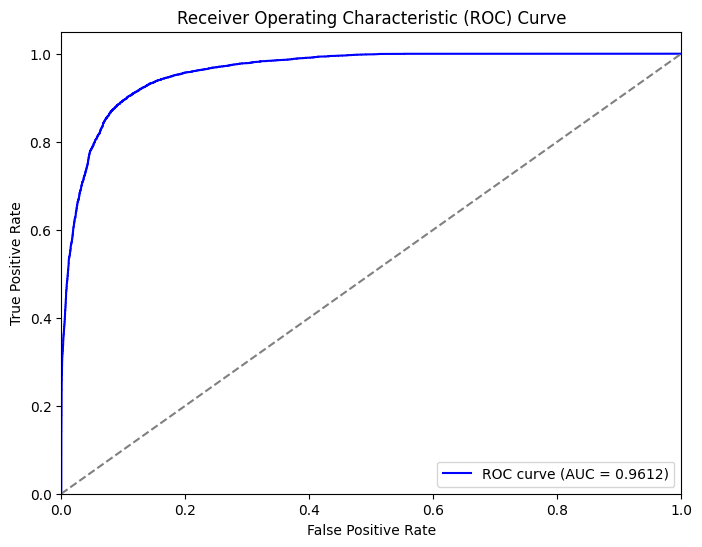

AUC Score: 0.9612


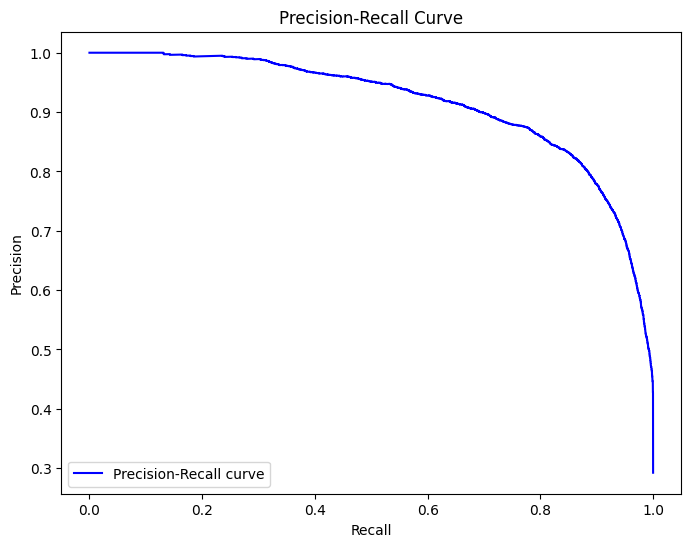

In [23]:
# After model training
y_prob = bst.predict(X_test)  # Probabilities for positive class

# 1. Plot ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 2. Print AUC Score
print(f"AUC Score: {roc_auc:.4f}")

# 3. Optional: Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()



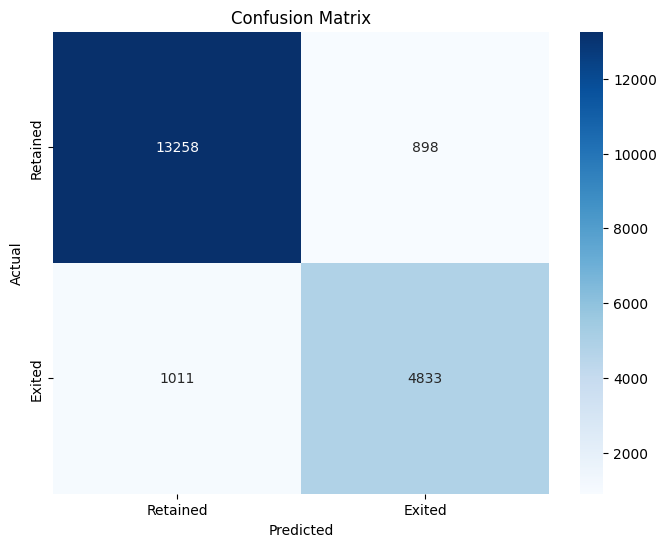

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Retained', 'Exited'], yticklabels=['Retained', 'Exited'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [25]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=42), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters found
print(f"Best Parameters: {grid_search.best_params_}")

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {accuracy_best:.4f}")


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Best Model Accuracy: 0.9046


In [26]:
from sklearn.metrics import accuracy_score

# Train Accuracy
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Test Accuracy
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Accuracy: 0.9100
Test Accuracy: 0.9046


In [27]:
best_model.booster_.save_model('/content/drive/MyDrive/lgb_best_model.txt')